# Subsurface Oxygen $O_2$

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import os.path as op
import sys

import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_int import plot_timeseries_interactive, plot_oni_index_th
from ind_setup.plotting import plot_base_map, plot_map_subplots, add_oni_cat

sys.path.append("../../../functions")
from data_downloaders import download_oni_index

## Setup

Define area of interest

In [2]:
#Area of interest
lon_range  = [129.4088, 137.0541]
lat_range = [1.5214, 11.6587]

EEZ shapefile

In [3]:
path_figs = "../../../matrix_cc/figures"

In [4]:
shp_f = op.join(os.getcwd(), '..', '..','..', 'data/Palau_EEZ/pw_eez_pol_april2022.shp')
shp_eez = gpd.read_file(shp_f)

### Load Data

Superficial depth

In [5]:
data_xr = xr.open_dataset(op.join(os.getcwd(), '..', '..','..', 'data/data_phyc_o2_ph.nc')).isel(depth = 0)
dataset_id = 'o2'
label = 'O2 [µmol/kg]'

## Analysis

### Plotting

#### Average

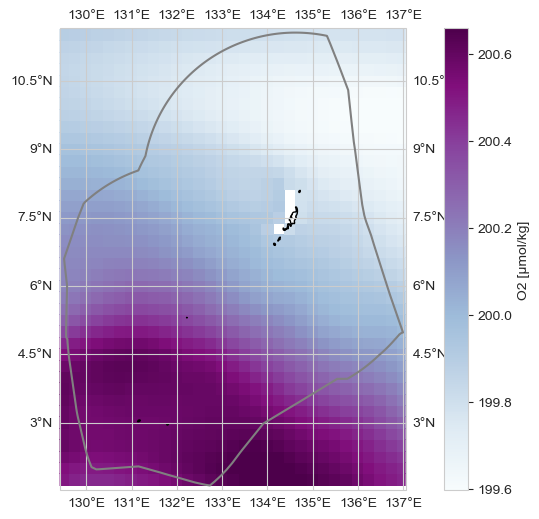

In [6]:
ax = plot_base_map(shp_eez = shp_eez, figsize = [10, 6])
im = ax.pcolor(data_xr.longitude, data_xr.latitude, data_xr.mean(dim='time')[dataset_id], transform=ccrs.PlateCarree(), 
                cmap = 'BuPu', 
                vmin = np.nanpercentile(data_xr.mean(dim = 'time')[dataset_id], 1), 
                vmax = np.nanpercentile(data_xr.mean(dim = 'time')[dataset_id], 99))
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())
plt.colorbar(im, ax=ax, label= label)
plt.savefig(op.join(path_figs, 'F17_O2_mean_map.png'), dpi=300, bbox_inches='tight')


#### Annual average

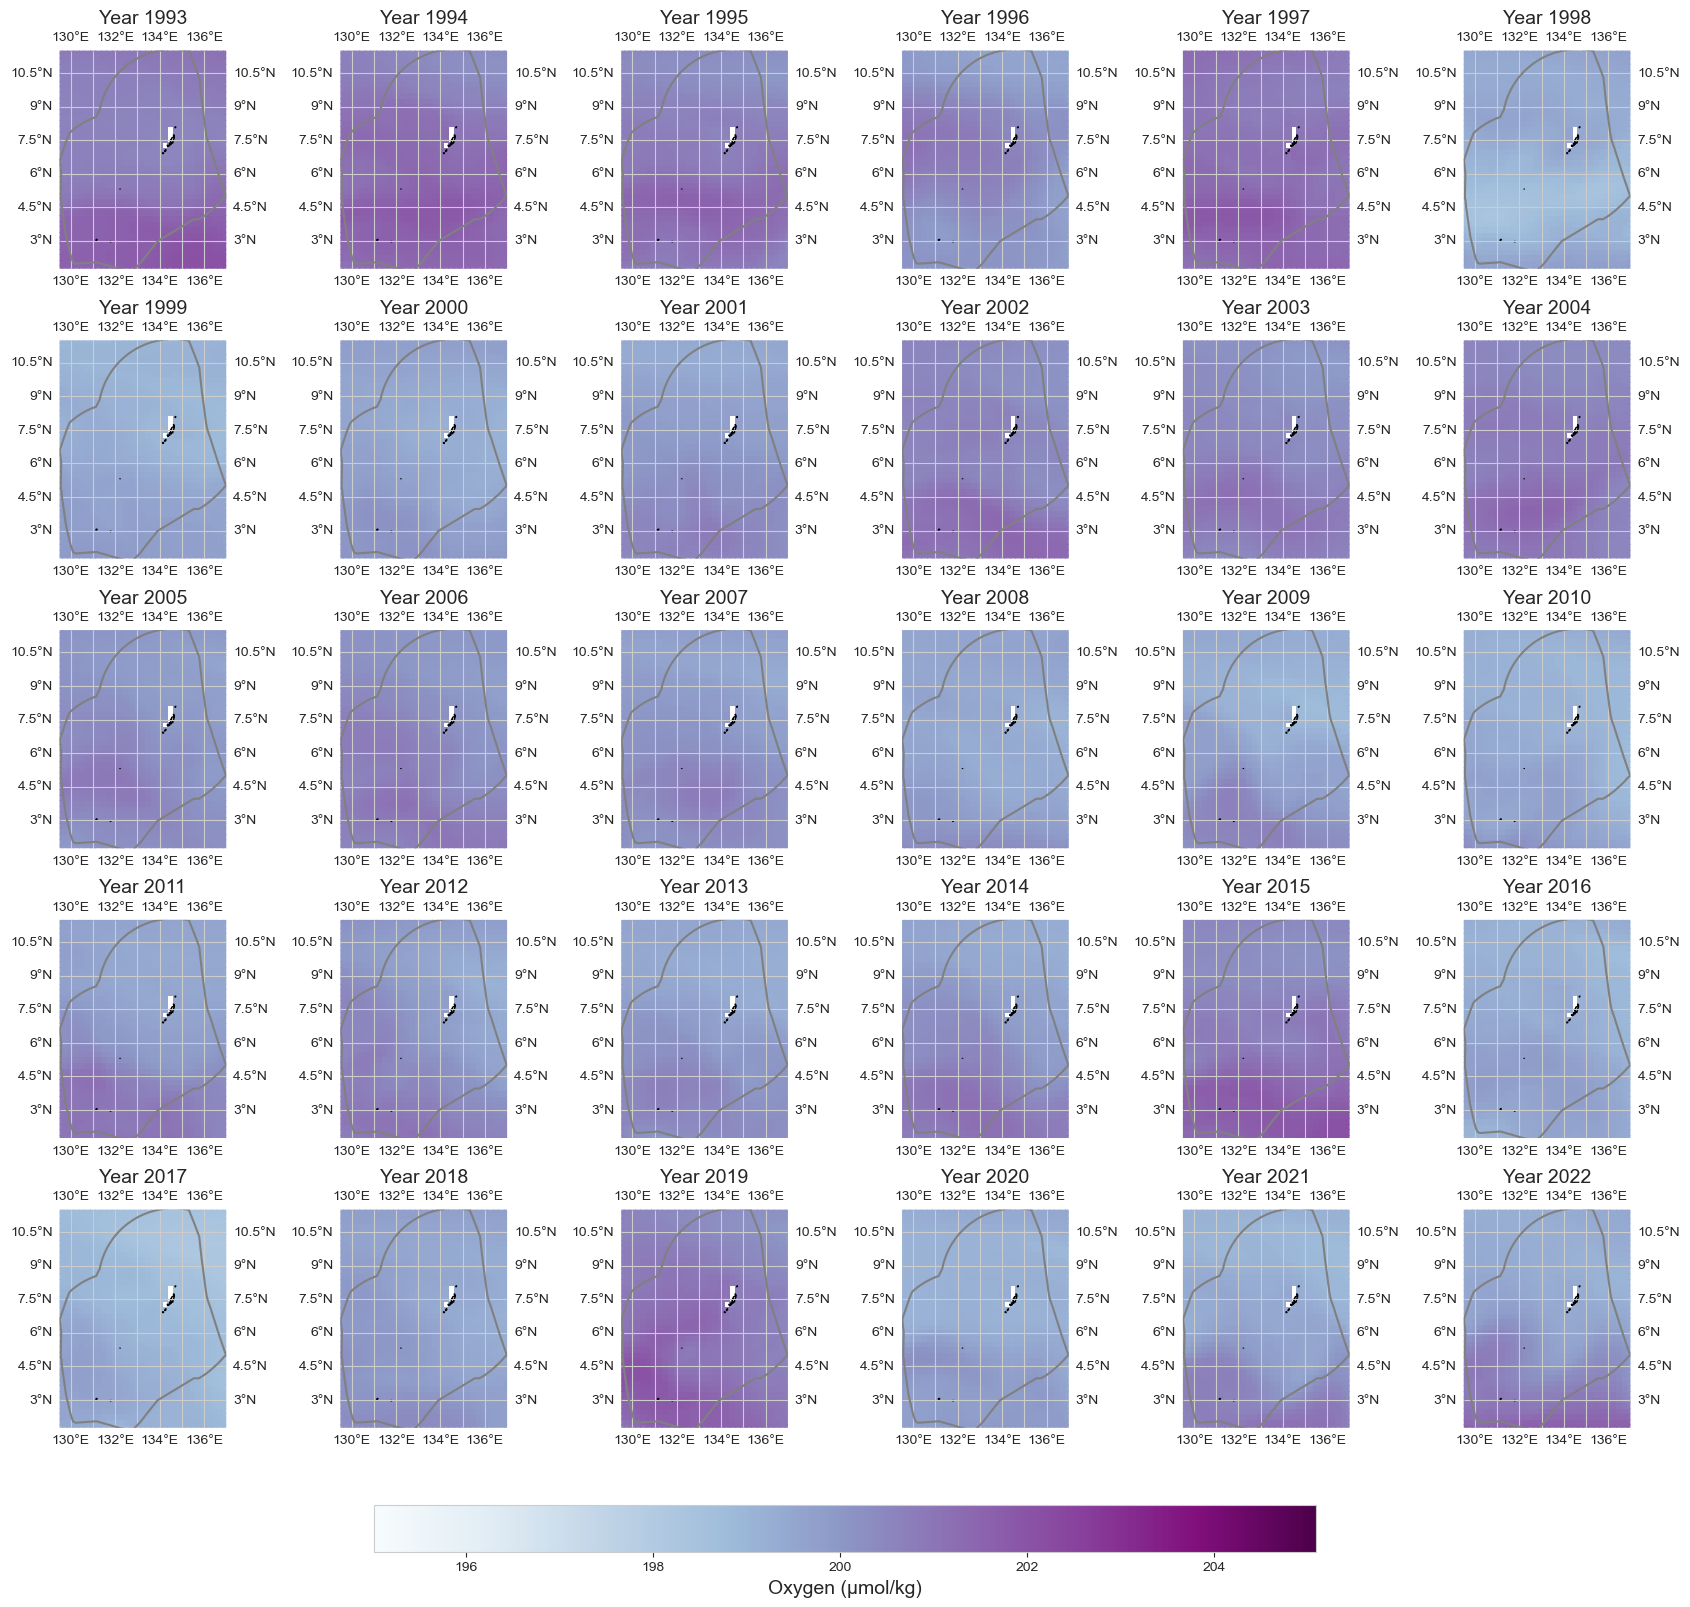

In [7]:
data_y = data_xr.resample(time='1YE').mean()
im = plot_map_subplots(data_y, dataset_id, shp_eez = shp_eez, cmap = 'BuPu', 
                  vmin = np.nanpercentile(data_xr.min(dim = 'time')[dataset_id], 1), 
                  vmax = np.nanpercentile(data_xr.max(dim = 'time')[dataset_id], 99),
                  cbar = 1)

#### Annual anomaly

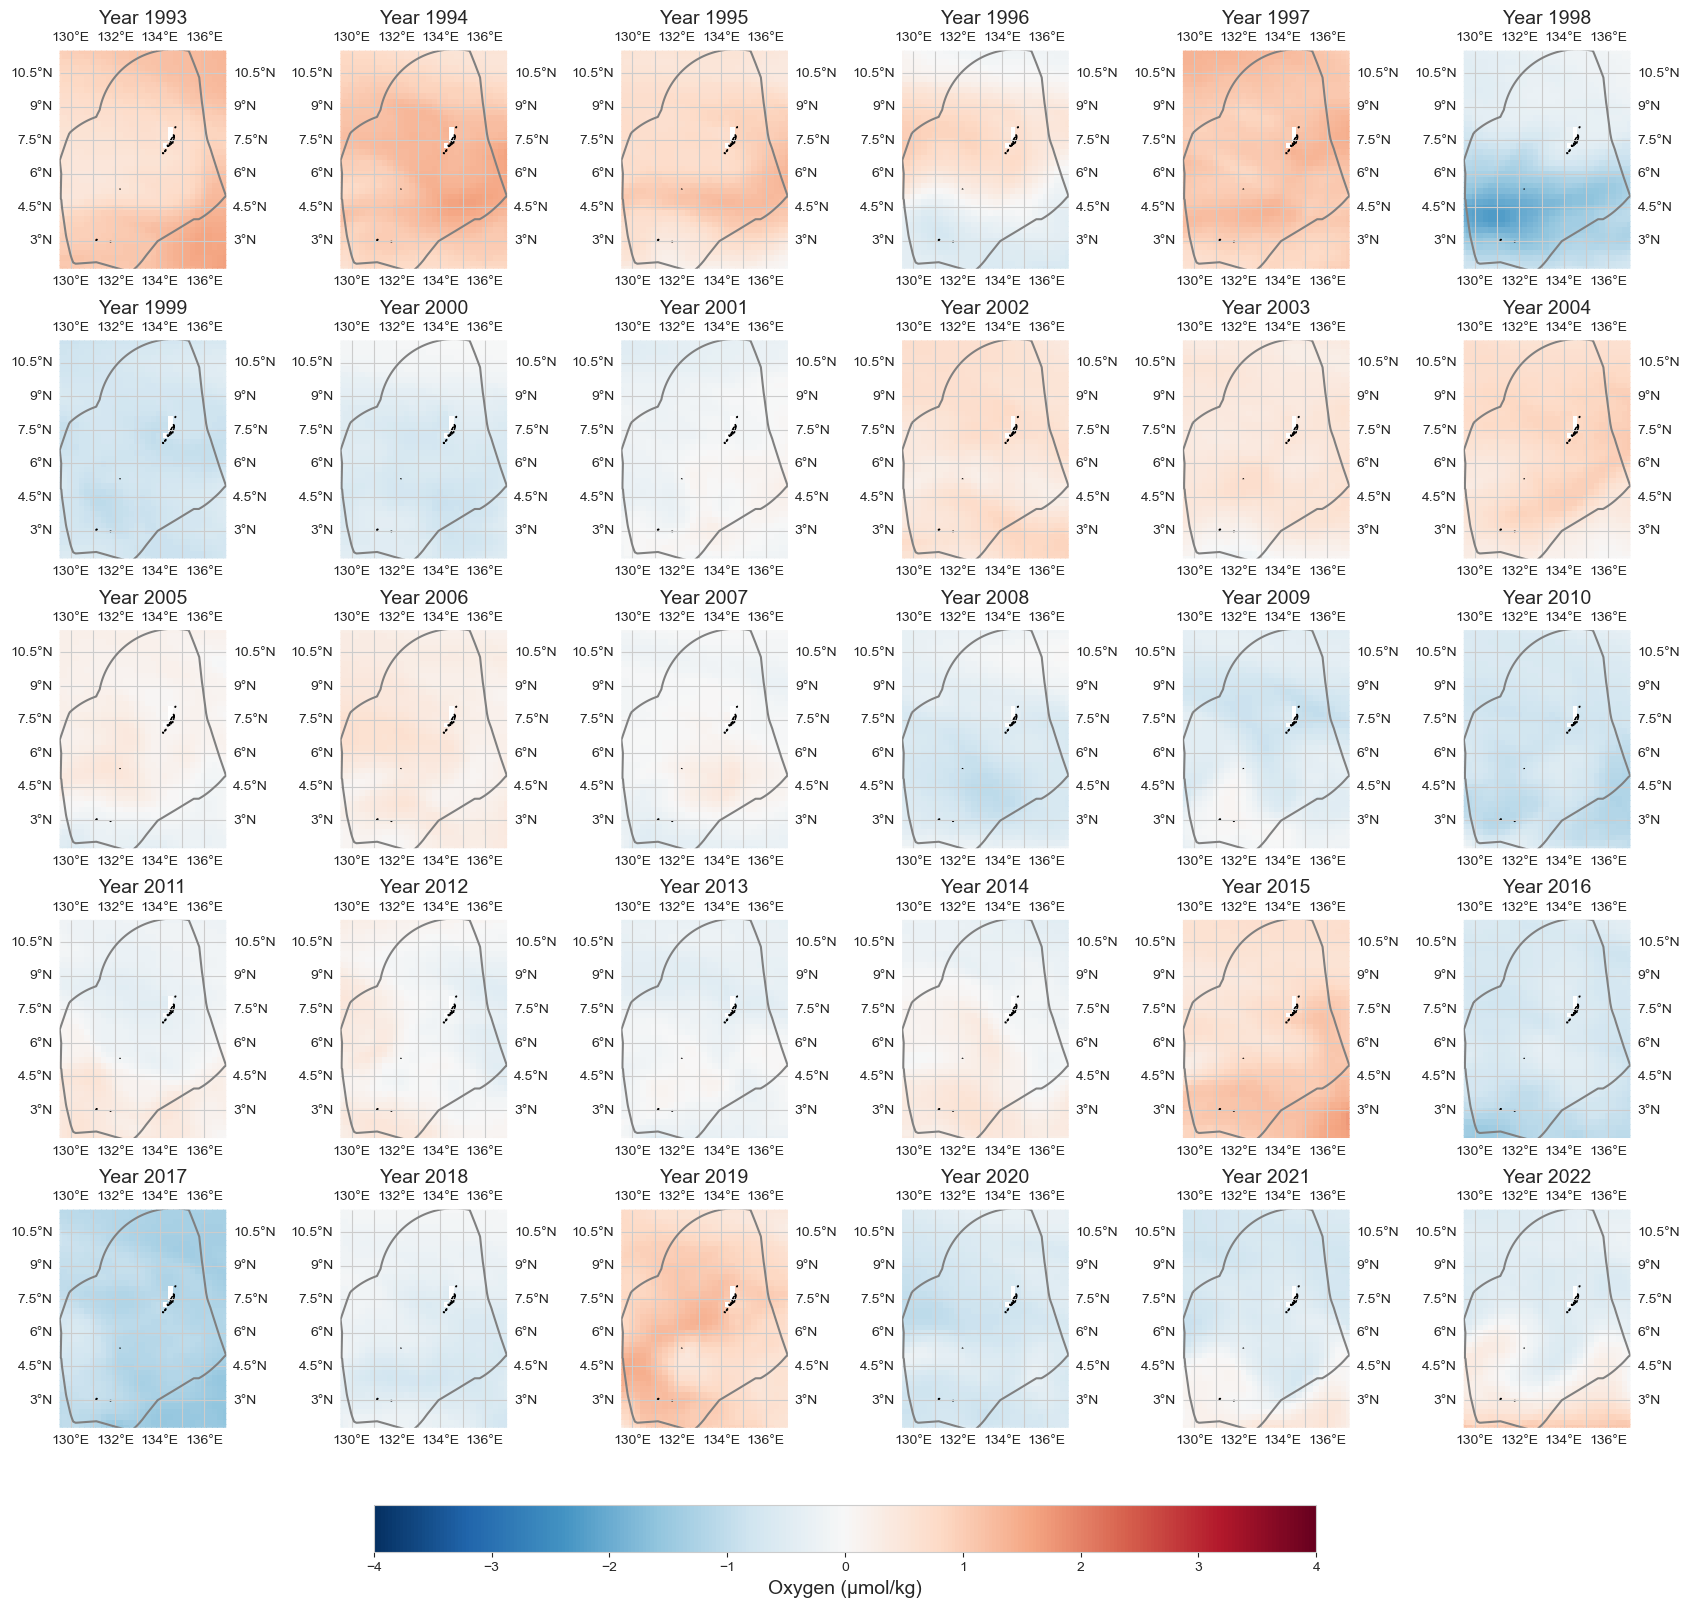

In [8]:
data_an = data_y - data_xr.mean(dim='time')
fig = plot_map_subplots(data_an, dataset_id, shp_eez = shp_eez, cmap='RdBu_r', vmin=-4, vmax=4, cbar = 1)

#### Average over area

In [9]:
dict_plot = [{'data' : data_xr.mean(dim = ['longitude', 'latitude']).to_dataframe(), 
              'var' : dataset_id, 'ax' : 1, 'label' : f'{label} - MEAN AREA'},]

In [10]:
fig = plot_timeseries_interactive(dict_plot, trendline=True, scatter_dict = None, figsize = (25, 12), label_yaxes = label);
fig.write_html(op.join(path_figs, 'F17_O2_mean_trend.html'), include_plotlyjs="cdn")


#### Timeseries at a given point

In [11]:
loc = [7.37, 134.7]
dict_plot = [{'data' : data_xr.sel(longitude=loc[1], latitude=loc[0], method='nearest').to_dataframe(), 
              'var' : dataset_id, 'ax' : 1, 'label' : f'{label} at [{loc[0]}, {loc[1]}]'},]

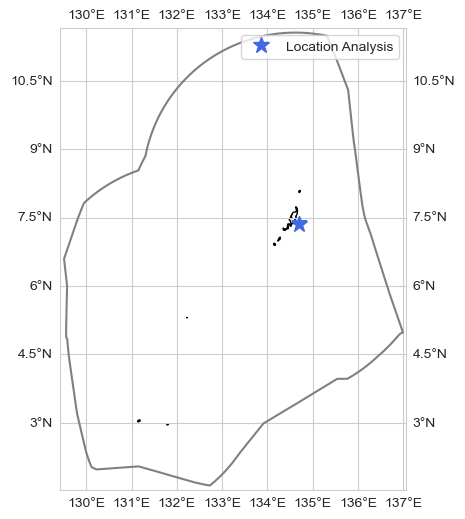

In [12]:
ax = plot_base_map(shp_eez = shp_eez, figsize = [10, 6])
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())
ax.plot(loc[1], loc[0], '*', markersize = 12, color = 'royalblue', transform=ccrs.PlateCarree(), label = 'Location Analysis')
ax.legend()

In [13]:
fig = plot_timeseries_interactive(dict_plot, trendline=True, scatter_dict = None, figsize = (25, 12), label_yaxes = label);

### ONI index analysis

In [14]:
p_data = 'https://psl.noaa.gov/data/correlation/oni.data'
df1 = download_oni_index(p_data)

In [15]:
lims = [-.5, .5]
plot_oni_index_th(df1, lims = lims)

Group by ONI category

In [16]:
df1 = add_oni_cat(df1, lims = lims)
df1['ONI'] = df1['oni_cat']
data_xr['ONI'] = (('time'), df1.iloc[np.intersect1d(data_xr.time, df1.index, return_indices=True)[2]].ONI.values)
data_xr['ONI_cat'] = (('time'), np.where(data_xr.ONI < lims[0], -1, np.where(data_xr.ONI > lims[1], 1, 0)))
data_oni = data_xr.groupby('ONI_cat').mean()

#### Average

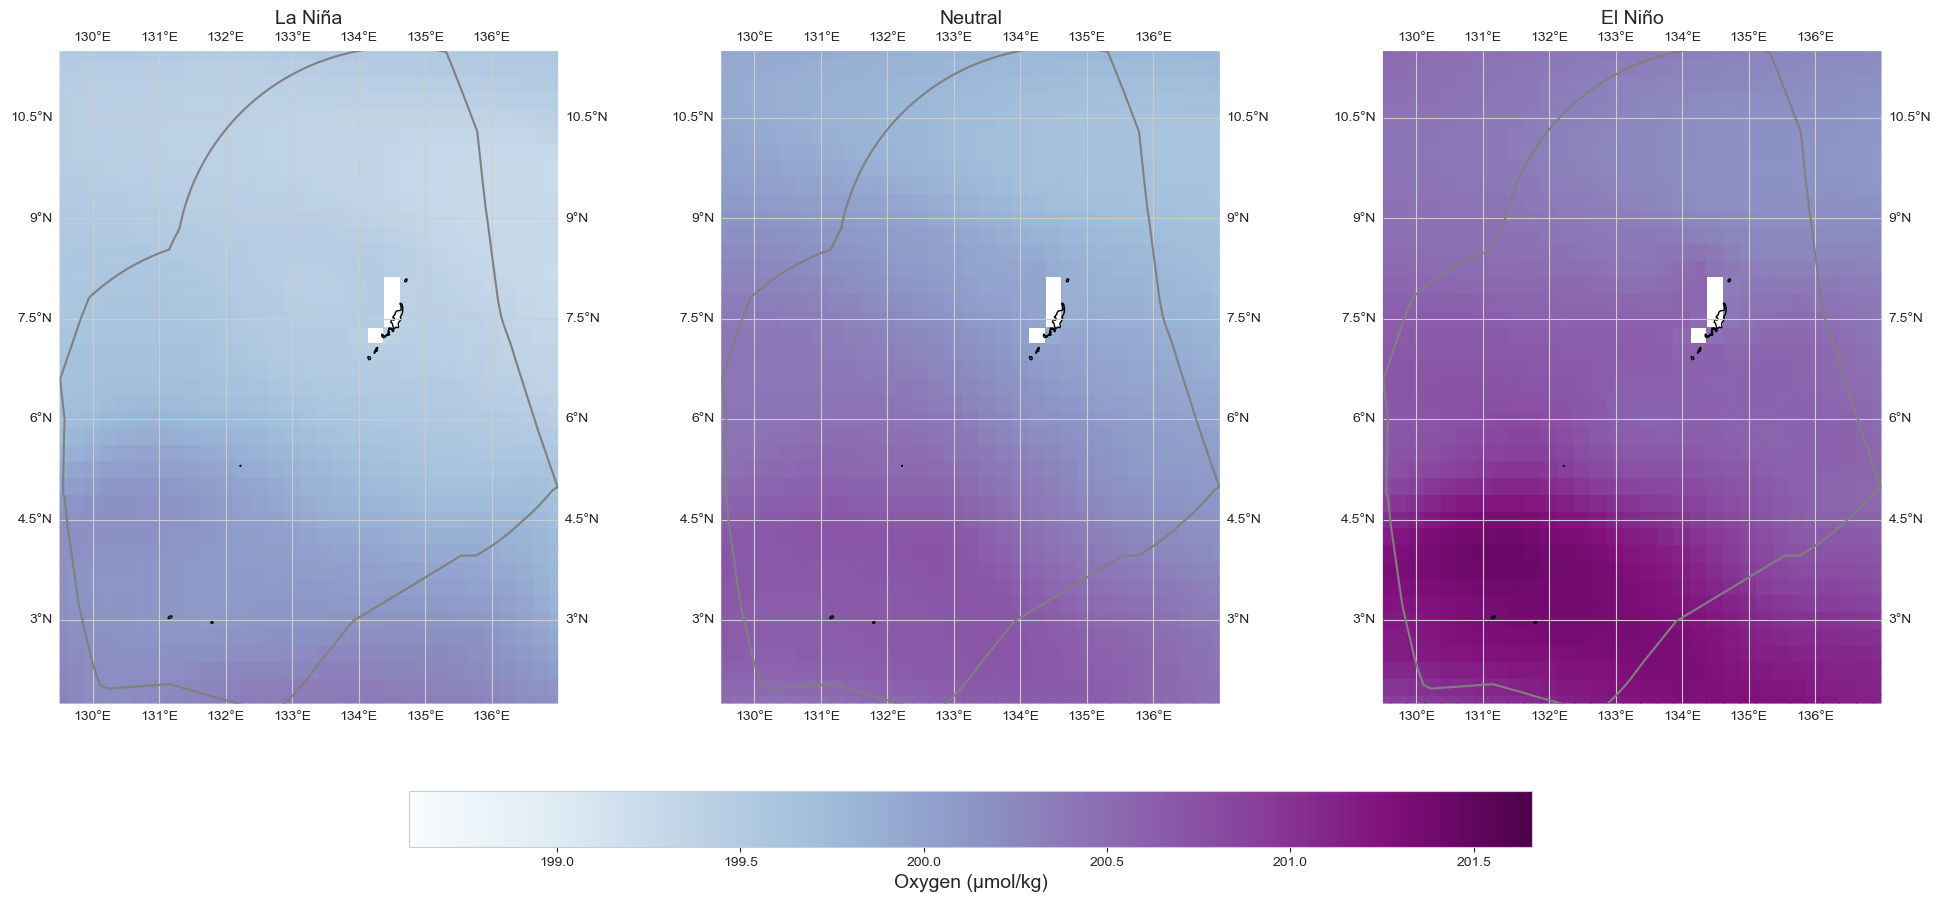

In [17]:
fig = plot_map_subplots(data_oni, dataset_id, shp_eez = shp_eez, cmap = 'BuPu', 
                  vmin = np.nanpercentile(data_xr.mean(dim = 'time')[dataset_id], 1) - 1, 
                  vmax = np.nanpercentile(data_xr.mean(dim = 'time')[dataset_id], 99) + 1,
                  sub_plot= [1, 3], figsize = (20, 9),  cbar = True, cbar_pad = 0.1,
                  titles = ['La Niña', 'Neutral', 'El Niño'],)
plt.savefig(op.join(path_figs, 'F17_O2_ENSO.png'), dpi=300, bbox_inches='tight')


#### Anomaly

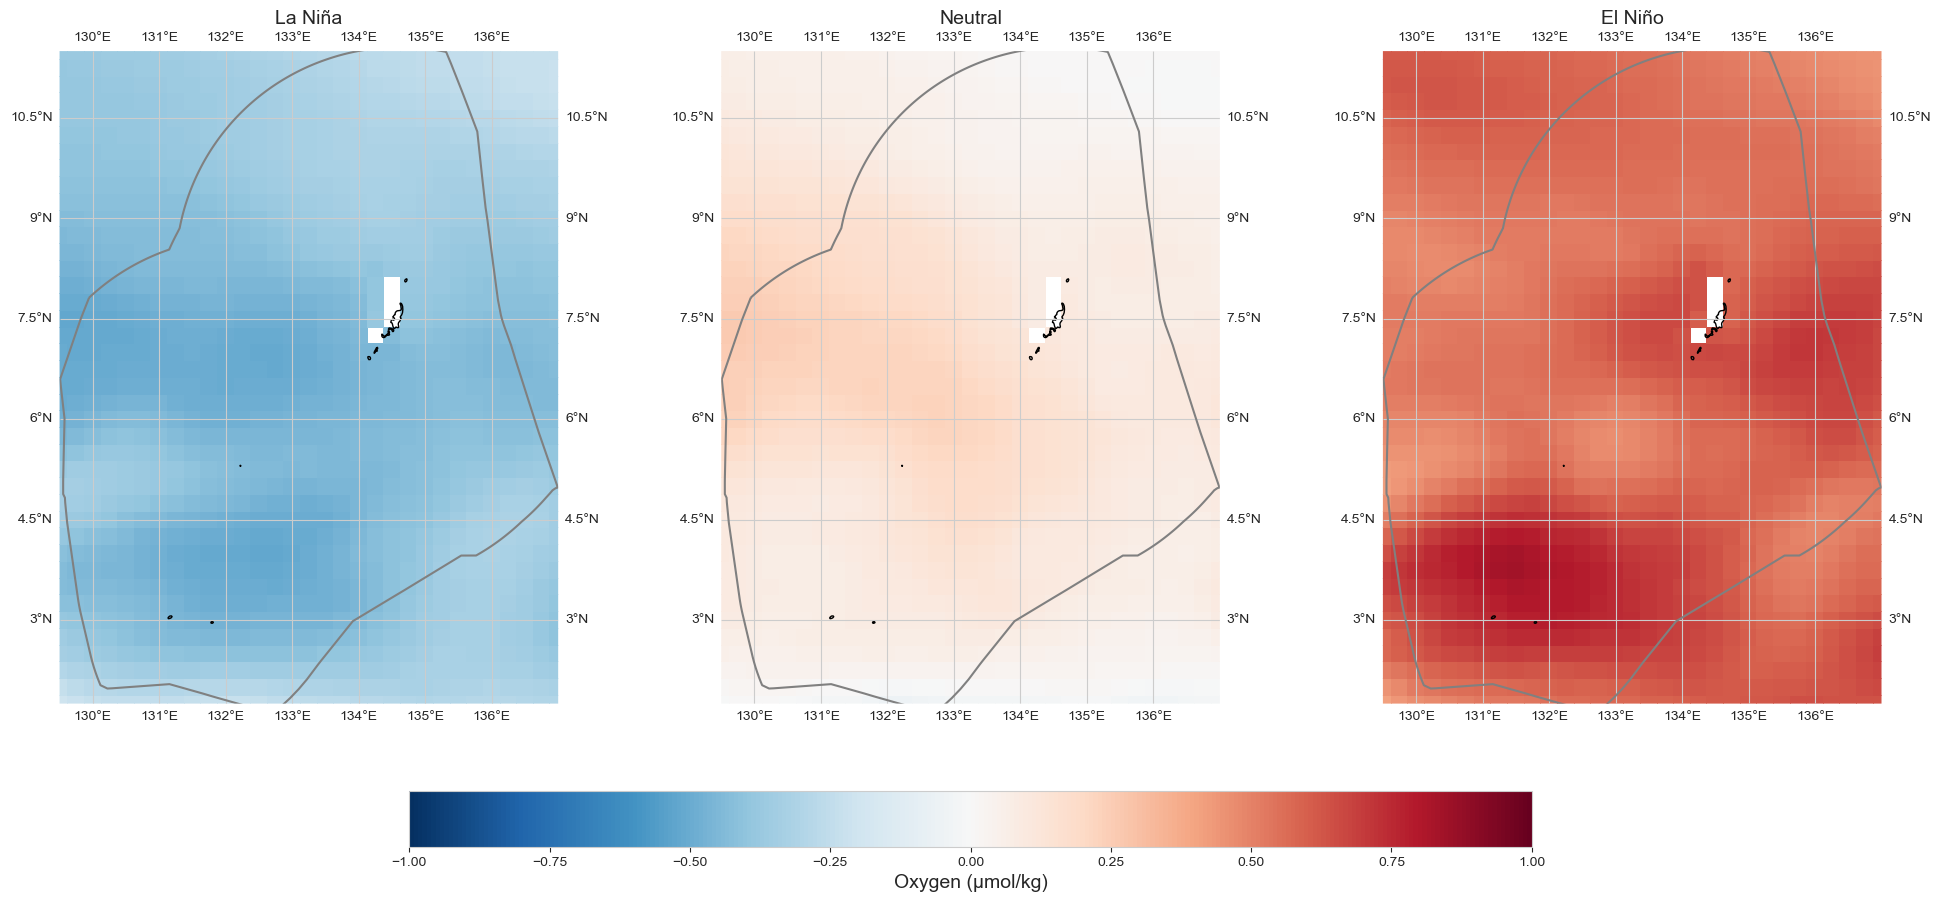

In [18]:
data_an = data_oni - data_xr.mean(dim='time')
fig = plot_map_subplots(data_an, dataset_id, shp_eez = shp_eez, cmap='RdBu_r', vmin=-1, vmax=1,
                  sub_plot= [1, 3], figsize = (20, 9),  cbar = True, cbar_pad = 0.1,
                  titles = ['La Niña', 'Neutral', 'El Niño'],)